In [1]:
import wandb
#from wandb import Api
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

%load_ext autoreload
%autoreload 2

In [2]:
HUES = {}
HUES["GCN-Transformer"] = "Red"
HUES["GCN-Avg"] = "Purple"
HUES["GCN-PretrainedT-CurrentDB"] = "Gray"
HUES["GCN-PretrainedT-NoCurrentDB"] = "Green"
HUES["GCN-PreatinedT-NoCurrentDB-NoActualFeats"] = "Black"

In [3]:
api = wandb.Api()

In [12]:
runs = api.runs("pari/LatencyPredictor",
    {"$and": [
      #{"config.eval_epoch": 60},
      {"config.eval_epoch": 50},
      #{"config.traindata_dir": "LatencyCollectorResults/background"},
      {"$or": [
            {"$and": [
                {"tags":"2a"},
            ]},
          {
            "config.config":  "configs/baselines/config_avg.yaml",
          },
          {
            "config.config":  "configs/baselines/config_trans.yaml",
          },
      ]} 
    ]
    })

print(f"Found {len(runs)} runs")

Found 180 runs


In [13]:
import time
start = time.time()

dfs = []

cur_run = None
for run in runs:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(dfs))

took:  1.064176082611084
157


In [14]:
df = pd.concat(dfs)
print(len(df))

157


In [15]:
def get_alg(row):
    if "avg" in row["config"]:
        return "GCN-Avg"
    elif "trans" in row["config"]:
        return "GCN-Transformer"
    else:
        return row["sys_net_pretrained_fn"]
#     elif "evals" in row["config"]:
#         if "all_noimdb_128_col1_fixed.wt" in row["sys_net_pretrained_fn"]:
#             return "GCN-PretrainedT-CurrentDB"
#         elif row["sys_net_pretrained_fn"] == "models2/noimdb_wk_128.wt":
#             return "GCN-PretrainedT-CurrentDB"
#         elif row["sys_net_pretrained_fn"] == "models2/noimdb_128_fixed.wt":
#             #return "GCN-PreatinedT-NoCurrentDB-NoActualFeats"
#             return None
#         else:
#             return "GCN-PretrainedT-NoCurrentDB"
        
        #return row["sys_net_pretrained_fn"]
    
def get_workload(row):
    if "stack" in row["tags"]:
        return "Stack"
    elif "tpch" in row["tags"]:
        return "Tpch"
    elif "zdb" in row["tags"]:
        return "zdbs"
    else:
        return "IMDb"
     
df["alg"] = df.apply(lambda x: get_alg(x),axis=1)
df["workload"] = df.apply(lambda x: get_workload(x),axis=1)

In [16]:
df = df[df["alg"].notna()]

In [17]:
print(len(df))
print(set(df["num_instances"]))
print(set(df["seed"]))
print(set(df["config"]))
print(set(df["sys_net_pretrained_fn"]))
print(set(df["alg"]))
print(set(df["tags"]))
print(set(df["workload"]))

157
{1, 2, 3, 4}
{1, 2, 3}
{'configs/evals/config_bg_nostack.yaml', 'configs/baselines/config_avg.yaml', 'configs/evals/config_noimdb4.yaml', 'configs/evals/config_bg_noimdb4.yaml', 'configs/evals/config_noimdbwk.yaml', 'configs/baselines/config_trans.yaml'}
{'models/all_noimdb_128_col1_fixed.wt', 'models2/bg_stack_attention.wt', 'models2/bg_imdball_attention.wt', 'models2/noimdb_128_filters_actual_fixed.wt', 'avg', None}
{'models/all_noimdb_128_col1_fixed.wt', 'models2/bg_stack_attention.wt', 'models2/bg_imdball_attention.wt', 'models2/noimdb_128_filters_actual_fixed.wt', 'GCN-Avg', 'GCN-Transformer'}
{'exp2_stack', 'exp10_single_zdbs', 'exp8_single_stack', 'exp1_single,exp2_single,exp3_single', 'exp1', 'exp1_single,exp2_single,exp3_single,'}
{'Stack', 'zdbs', 'IMDb'}


In [18]:
# FN_TMP = "{}-{}.pdf"
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
#     EB="sd"
#     TO_PLOT = ['Final-LatencyMSE-train-mean', 'Final-LatencyMSE-test-mean']
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

#     ## train
#     ax = axs[0]
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
#                 ax=ax, errorbar=EB, 
#                 #palette=HUES
#                )
#     legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                        frameon=False)

#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], 
#                 errorbar=EB, 
#                 #palette=HUES
#                )
#     axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "MSE")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")
    
#     TO_PLOT = ['Final-LatencyQError-train-mean', 'Final-LatencyQError-test-mean']
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
#                #palette=HUES)
#                 )
#     legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                frameon=False)
    
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], errorbar=EB,
#                #palette=HUES
#                )
#     axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "Q-Error")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")

Stack
zdbs
IMDb


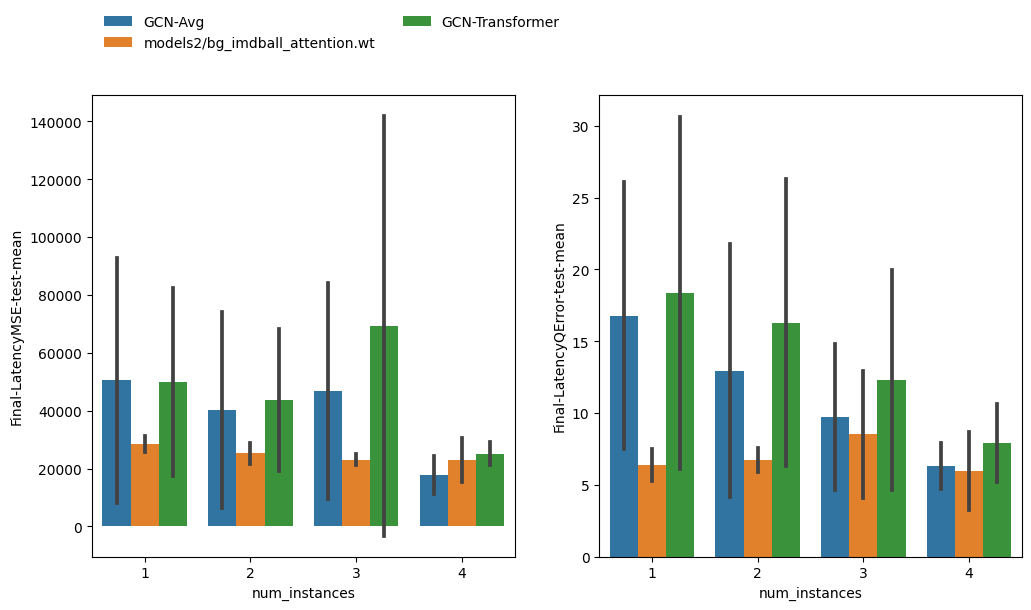

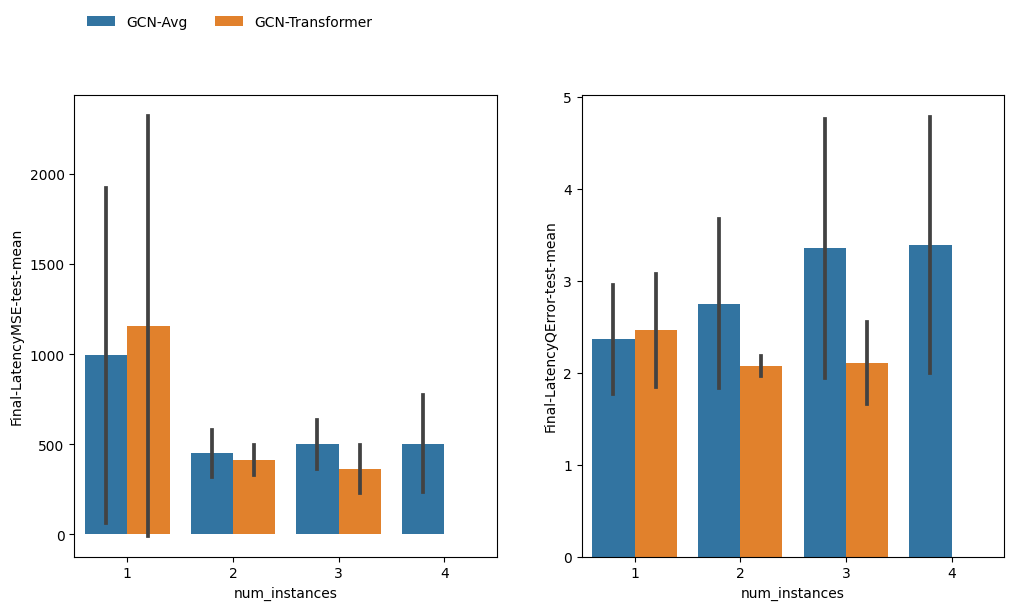

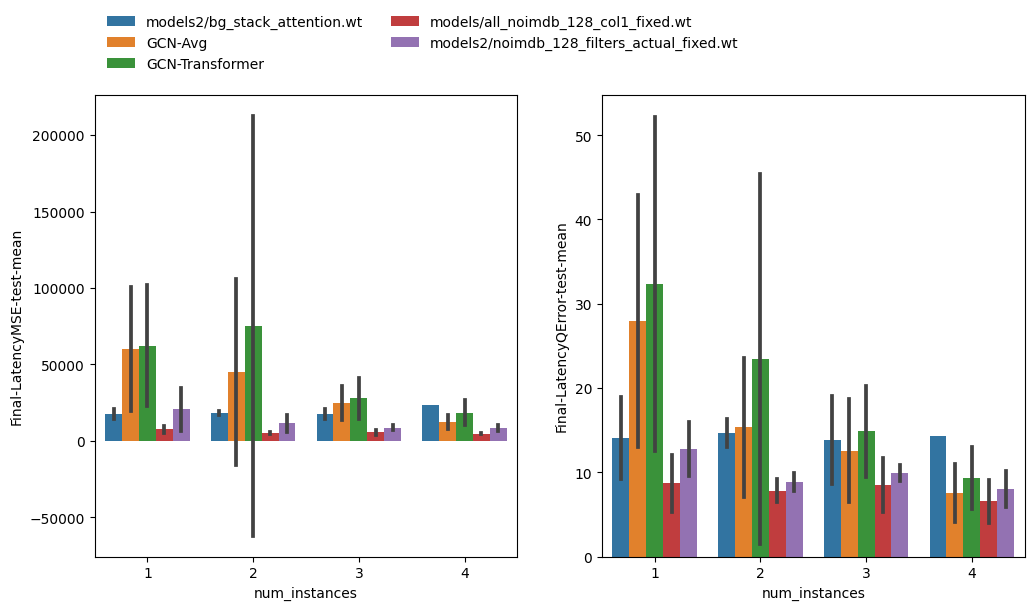

In [19]:
FN_TMP = "{}-{}.pdf"
for wk in set(df["workload"]):
    print(wk)
    tmp = df[df["workload"] == wk]
    EB="sd"
    TO_PLOT = ['Final-LatencyMSE-test-mean', 'Final-LatencyQError-test-mean']
    fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

    ## train
    ax = axs[0]
    sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
                ax=ax, errorbar=EB, 
                #palette=HUES
               )
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
                       frameon=False)

    sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], 
                errorbar=EB, 
                #palette=HUES
               )
    
    axs[1].legend().remove()
    
    
#     fn = FN_TMP.format(wk, "MSE")
    
#     #print(fn)
#     #plt.savefig(fn, bbox_inches="tight")
    
#     TO_PLOT = ['Final-LatencyQError-test-mean']
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
#                #palette=HUES)
#                 )
#     legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                frameon=False)
    
# #     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], errorbar=EB,
# #                #palette=HUES
# #                )
# #     axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "Q-Error")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")